<center> <h1> Enhanced Index Tracking with Distributionally Robust Optimization <h1/> <center/>

## Imports

In [398]:
import sys
import os
import re
import glob
import datetime as dt
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mosek.fusion import *

## Model Controller

In [399]:
shortingCapacity = 0.00;

models = ["Program (2.38)","Program (2.42)", "Program (2.43)"]
selectedModel = models[2];

## Load Training and Test Data

In [400]:
whichData = "UU";

In [401]:
inSampleDU = pd.read_csv("./Data/Data from Guastaroba (2020)/CSV/IS-GMS-{}.csv".format(whichData), header=None);

outSampleDD = pd.read_csv("./Data/Data from Guastaroba (2020)/CSV/OoS-GMS-DD.csv", header=None);
outSampleDU = pd.read_csv("./Data/Data from Guastaroba (2020)/CSV/OoS-GMS-DU.csv", header=None);
outSampleUD = pd.read_csv("./Data/Data from Guastaroba (2020)/CSV/OoS-GMS-UD.csv", header=None);
outSampleUU = pd.read_csv("./Data/Data from Guastaroba (2020)/CSV/OoS-GMS-UU.csv", header=None);

In [402]:
IndexOoS = outSampleDD.pct_change();
IndexOoS = IndexOoS.values[:,0]
IndexOoS[0] = 0;
AssetsOoS = outSampleDD.pct_change();
AssetsOoS = AssetsOoS.values[:,1:]
AssetsOoS[0,:] = 0;

IndexOoS1 = outSampleDU.pct_change();
IndexOoS1 = IndexOoS1.values[:,0]
IndexOoS1[0] = 0;
AssetsOoS1 = outSampleDU.pct_change();
AssetsOoS1 = AssetsOoS1.values[:,1:]
AssetsOoS1[0,:] = 0;

IndexOoS2 = outSampleUD.pct_change();
IndexOoS2 = IndexOoS2.values[:,0]
IndexOoS2[0] = 0;
AssetsOoS2 = outSampleUD.pct_change();
AssetsOoS2 = AssetsOoS2.values[:,1:]
AssetsOoS2[0,:] = 0;

IndexOoS3 = outSampleUU.pct_change();
IndexOoS3 = IndexOoS3.values[:,0]
IndexOoS3[0] = 0;
AssetsOoS3 = outSampleUU.pct_change();
AssetsOoS3 = AssetsOoS3.values[:,1:]
AssetsOoS3[0,:] = 0;

In [403]:
Index = inSampleDU.iloc[:,0].values
Assets = inSampleDU.iloc[:,1:].values

## Enhanced Index Tracking (without DRO)

We start by defining a simple model.

In [404]:
alphaAnnualy = 0.04;
alphaWeekly = (1 + alphaAnnualy)**(1/52) - 1;

Then the model will look as follows.

$$
\text{min} \ \ \mathbb{E}[|R_{\textbf{x}} - R_{\alpha}^{I}|] + \gamma \cdot \text{CVaR}[R_{\textbf{x}} - R_{\alpha}^{I}]
$$

Appropriate constraints are of course also implemented.

In [405]:
T,N = Assets.shape;
probs = np.ones(T)*1/T;

In [406]:
mu = np.mean(Assets, axis=0);
indexAlpha = Index + alphaWeekly;

For now we construct a vector of equally weighted scenarios.

In [407]:
pi = np.ones(T)*(1/T);

In [408]:
# Specifies model in Equation 2.38.
if selectedModel == models[0]:

    with Model("markowitz") as M: 

        # Settings
        M.setLogHandler(sys.stdout)

        # Decision variable (fraction of holdings in each security)
        # The variable x is the fraction of holdings in each security.
        x = M.variable("x", N, Domain.greaterThan(-shortingCapacity))
        y = M.variable("y", T, Domain.greaterThan(0.0))

        # Auxiliaries
        eBudget = np.ones((N, 1));

        # Objective
        expectedDeviation = Expr.dot(y, pi);
        M.objective('obj', ObjectiveSense.Minimize, expectedDeviation);

        # Budget constraint
        M.constraint('budgetConstraint', Expr.dot(eBudget, x), Domain.equalsTo(1)) 
       
        # TE constraint
        M.constraint('TEConstraint1', Expr.sub(Expr.sub(Expr.mul(Assets, x), indexAlpha), y), Domain.lessThan(0.0)) 
        M.constraint('TEConstraint2', Expr.add(Expr.sub(Expr.mul(Assets, x), indexAlpha), y), Domain.greaterThan(0.0)) 
        
        columns = ["obj", "alpha", "TE"] + [i for i in range(1,101)];
        df_result_shorting = pd.DataFrame(columns=columns)

        # Solve optimization
        M.solve();

        prosta = M.getProblemStatus();

        if prosta != ProblemStatus.PrimalInfeasible:

            # Calculate return
            trackingError = np.dot(pi, y.level());
            #CVaR = nu.level() + betaMod.getValue()[0] * np.dot(pi, u.level());

            # Save row
            row = pd.DataFrame([M.primalObjValue(), alphaAnnualy, trackingError] + list(x.level()), index=columns, columns=[idxGamma]);

            # Concatenate with exisiting results
            df_result_shorting = pd.concat([df_result_shorting, row.T], axis=0);
            

        else:
            print("Model is PrimalInfeasible!");
                
if selectedModel == models[1]:

    with Model("markowitz") as M: 

        # Settings
        M.setLogHandler(sys.stdout)

        # Decision variable (fraction of holdings in each security)
        # The variable x is the fraction of holdings in each security.
        x = M.variable("x", N, Domain.greaterThan(-shortingCapacity))
        nu = M.variable("nu", Domain.unbounded())
        u = M.variable("u", T, Domain.greaterThan(0.0))

        # Parameters
        gamma = M.parameter('gamma');
        betaMod = M.parameter('beta');

        # Auxiliaries
        eCVaR = np.ones((T, 1));
        eBudget = np.ones((N, 1));

        # Objective
        expectedCVaR = Expr.add(nu, Expr.mul(betaMod, Expr.dot(pi, u)));
        M.objective('obj', ObjectiveSense.Minimize, Expr.mul(gamma, expectedCVaR));

        # Budget constraint
        M.constraint('budgetConstraint', Expr.dot(eBudget, x), Domain.equalsTo(1)) 
       
        # CVaR constraint
        M.constraint('CVaRConstraint', Expr.add(Expr.sub(Expr.mul(Assets, x), indexAlpha), Expr.add(Expr.mul(nu, eCVaR), u)), Domain.greaterThan(0.0)) 

        # Then we move on to solve it
        gammas = np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0]);
        betas = np.array([0.80, 0.90, 0.95, 0.99]);

        columns = ["obj", "gamma", "alpha", "beta", "CVaR"] + [i for i in range(1,101)];
        df_result_shorting = pd.DataFrame(columns=columns)

        for idxGamma, gammaNew in enumerate(gammas):
            for idxBeta, betaNew in enumerate(betas):

                # Update parameter
                gamma.setValue(gammaNew);
                betaMod.setValue(1/(1 - betaNew));

                # Solve optimization
                M.solve();

                prosta = M.getProblemStatus();

                if prosta != ProblemStatus.PrimalInfeasible:

                    # Calculate return
                    CVaR = nu.level() + betaMod.getValue()[0] * np.dot(pi, u.level());

                    # Save row
                    row = pd.DataFrame([M.primalObjValue(), gammaNew, alphaAnnualy, betaNew, CVaR[0]] + list(x.level()), index=columns, columns=[idxGamma]);

                    # Concatenate with exisiting results
                    df_result_shorting = pd.concat([df_result_shorting, row.T], axis=0);

                else:
                    continue;
                    
if selectedModel == models[2]:

    with Model("markowitz") as M: 

        # Verbose
        # M.setLogHandler(sys.stdout)

        # Decision variable (fraction of holdings in each security)
        # The variable x is the fraction of holdings in each security.
        x = M.variable("x", N, Domain.greaterThan(-shortingCapacity))
        y = M.variable("y", T, Domain.greaterThan(0.0))
        nu = M.variable("nu", Domain.unbounded())
        u = M.variable("u", T, Domain.greaterThan(0.0))

        # Parameters
        gamma = M.parameter('gamma');
        betaMod = M.parameter('beta');

        # Auxiliaries
        eCVaR = np.ones((T, 1));
        eBudget = np.ones((N, 1));

        # Objective
        expectedDeviation = Expr.dot(y, pi);
        expectedCVaR = Expr.add(nu, Expr.mul(betaMod, Expr.dot(pi, u)));
        M.objective('obj', ObjectiveSense.Minimize, Expr.add(expectedDeviation, Expr.mul(gamma, expectedCVaR)));

        # Budget constraint
        M.constraint('budgetConstraint', Expr.dot(eBudget, x), Domain.equalsTo(1)) 
 
        # TE constraint
        M.constraint('TEConstraint1', Expr.sub(Expr.sub(Expr.mul(Assets, x), indexAlpha), y), Domain.lessThan(0.0)) 
        M.constraint('TEConstraint2', Expr.add(Expr.sub(Expr.mul(Assets, x), indexAlpha), y), Domain.greaterThan(0.0))

        # CVaR constraint
        M.constraint('CVaRConstraint', Expr.add(Expr.sub(Expr.mul(Assets, x), indexAlpha), Expr.add(Expr.mul(nu, eCVaR), u)), Domain.greaterThan(0.0)) 

        # Then we move on to solve it
        gammas = np.linspace(0,1,100);
        betas = np.array([0.80, 0.90, 0.95, 0.99]);

        columns = ["obj", "gamma", "alpha", "TE", "beta", "CVaR"] + [i for i in range(1,101)];
        df_result_shorting = pd.DataFrame(columns=columns)

        for idxGamma, gammaNew in enumerate(gammas):
            for idxBeta, betaNew in enumerate(betas):

                # Update parameter
                gamma.setValue(gammaNew);
                betaMod.setValue(1/(1 - betaNew));

                # Solve optimization
                M.solve();

                prosta = M.getProblemStatus();

                if prosta != ProblemStatus.PrimalInfeasible:

                    # Calculate results
                    trackingError = np.dot(pi, y.level());
                    CVaR = nu.level() + betaMod.getValue()[0] * np.dot(pi, u.level());

                    # Save row
                    row = pd.DataFrame([M.primalObjValue(), gammaNew, alphaAnnualy, trackingError, betaNew, CVaR[0]] + list(x.level()), index=columns, columns=[idxGamma*4 + idxBeta]);

                    # Concatenate with exisiting results
                    df_result_shorting = pd.concat([df_result_shorting, row.T], axis=0);

                else:
                    continue;

In [409]:
selectedRow = 87;
betaSubset = 0.95;
subsetOfResults = df_result_shorting.loc[df_result_shorting.loc[:, 'beta'] == betaSubset, :];
selectRowOfSubset = subsetOfResults.iloc[selectedRow, :];
gamma, alpha, beta = selectRowOfSubset.loc[["gamma", "alpha", "beta"]].values;
optimalAllocation = subsetOfResults.iloc[selectedRow, :].values[6:]

In [410]:
print("Invests in {}% of the assets.".format(100*sum(optimalAllocation != 0.0)/len(optimalAllocation)))
print("Short position in {}% of the assets.".format(100*sum(optimalAllocation < 0.0)/len(optimalAllocation)))

Invests in 58.0% of the assets.
Short position in 0.0% of the assets.


Then we define the distributionally robust counterpart.

In [476]:
# Specifies model in Equation 2.38.
with Model("markowitz") as M: 

    # Settings
    M.setLogHandler(sys.stdout)
    
    # --------- Constants ---------
    delta = 0.0; # -> Shorting limit
    gamma = 0.6;
    beta = 0.95;
    N = 104; # -> Number of scenarios
    m = 100; # -> Number of available assets to invest in
    K = 4; # -> Number of piecewise affine functions to describe loss function
    
    # --------- Parameters ---------
    eps = M.parameter("WassersteinRadius"); # -> radius with respect to 1-norm
    eps.setValue(10**(-2));

    # Decision variables
    x = M.variable("x", m, Domain.greaterThan(-shortingCapacity)) # -> Weights in each asset
    s = M.variable("s_i", N);
    l = M.variable("lambda");
    tau = M.variable("tau"); # -> VaR in optimization problem

    # Auxiliaries
    eBudget = np.ones((m, 1));
    sOnes = np.ones((N, 1));

    # Objective
    firstTerm = Expr.mul(eps, l);
    secondTerm = Expr.mul(1/N, Expr.dot(s, sOnes));
    J = Expr.add(firstTerm, secondTerm);
    M.objective('obj', ObjectiveSense.Minimize, J);

    # Portfolio constraints
    M.constraint('budgetConstraint', Expr.dot(eBudget, x), Domain.equalsTo(1))

    # Definition of affine functions
    augX = [x, np.array([1])];
    a_k = [Expr.mul(augX, (1 - gamma/(1-beta))), Expr.mul(augX, -(1 + gamma/(1-beta))), xAug, -xAug];
    b_k = [Expr.mul(tau, gamma*(1 - gamma/(1-beta))), Expr.mul(tau, gamma*(1 - gamma/(1-beta))), Expr.mul(gamma, tau), Expr.mul(gamma, tau)];

    # Constraints related to DRO
    for k in range(K):
        M.constraint('maximumAffine', Expr.sub(Expr.add(Expr.mul(augAssets, a_k[k]), b_k[k]), s), Domain.lessThan(0.0));
        M.constraint('infinityNorm1', a_k[k] - l, Domain.lessThan(0.0));
        M.constraint('infinityNorm2', -a_k[k] - l, Domain.lessThan(0.0)); 

    columns = ["obj", "eps", "gamma", "beta", "delta"] + [i for i in range(1,m+1)];
    df_result_shorting = pd.DataFrame(columns=columns)

    # Solve optimization
    M.solve();

    prosta = M.getProblemStatus();

    if prosta != ProblemStatus.PrimalInfeasible:

        # Calculate return
        trackingError = np.dot(pi, y.level());
        #CVaR = nu.level() + betaMod.getValue()[0] * np.dot(pi, u.level());

        # Save row
        row = pd.DataFrame([M.primalObjValue(), eps.getValue()[0], gamma, beta, delta] + list(x.level()), index=columns, columns=[0]);

        # Concatenate with exisiting results
        df_result_shorting = pd.concat([df_result_shorting, row.T], axis=0);


    else:
        print("Model is PrimalInfeasible!");
                


ValueError: Invalid argument list mul([mosek.fusion.LinearVariable, array([1])],-10.99999999999999). Candidates are
	mosek.fusion.Expr.mul(mosek.fusion.Expression,array(double,ndim=1))
	mosek.fusion.Expr.mul(mosek.fusion.Matrix,mosek.fusion.Variable)
	mosek.fusion.Expr.mul(array(double,ndim=1),mosek.fusion.Expression)
	mosek.fusion.Expr.mul(double,mosek.fusion.Expression)
	mosek.fusion.Expr.mul(mosek.fusion.Matrix,mosek.fusion.Expression)
	mosek.fusion.Expr.mul(mosek.fusion.Parameter,mosek.fusion.Expression)
	mosek.fusion.Expr.mul(array(double,ndim=2),mosek.fusion.Expression)
	mosek.fusion.Expr.mul(mosek.fusion.Variable,mosek.fusion.Matrix)
	mosek.fusion.Expr.mul(mosek.fusion.Expression,array(double,ndim=2))
	mosek.fusion.Expr.mul(mosek.fusion.Expression,mosek.fusion.Parameter)
	mosek.fusion.Expr.mul(mosek.fusion.Expression,mosek.fusion.Matrix)
	mosek.fusion.Expr.mul(mosek.fusion.Expression,double)

## In-Sample Test

We start by calculating the portfolio for all levels.

In [411]:
portfolioReturns = np.matmul(Assets, optimalAllocation);
portfolio = np.zeros(T+1);
portfolio[1:] = portfolioReturns;

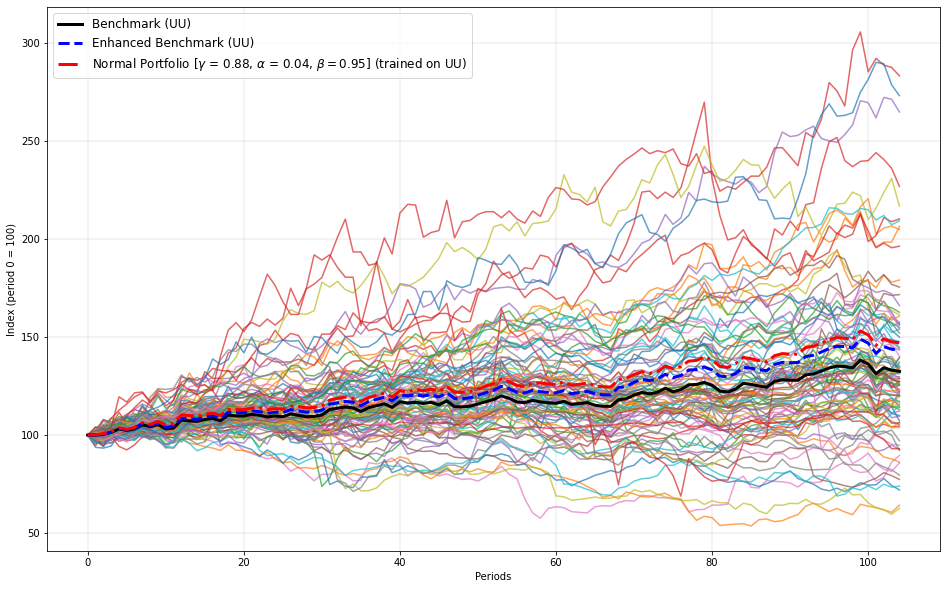

In [412]:
# Create figure
fig, ax = plt.subplots(figsize=(16, 10))

# Selected data
selectedData = np.concatenate((np.zeros((1, N)), Assets), axis=0);
selectedData = np.cumprod(selectedData + 1,axis=0) * 100;
ax.plot(selectedData[:,selectedData[-1,:] < 300], alpha = 0.7);
    
# Plot index
intermediateIndex = np.transpose(Index);
intermediateIndex = np.cumprod(intermediateIndex + 1)
index = np.insert(intermediateIndex, 0, 1.0, axis=0) * 100;
ax.plot(index, label="Benchmark ({})".format(whichData), linestyle='-', linewidth=3, color = 'black', alpha=1.0)

# Plot alphaIndex
intermediateIndex = np.transpose(indexAlpha);
intermediateIndex = np.cumprod(intermediateIndex + 1)
enhancedIndex = np.insert(intermediateIndex, 0, 1.0, axis=0) * 100;
ax.plot(enhancedIndex, label="Enhanced Benchmark ({})".format(whichData), linestyle='--', linewidth=3, color = 'blue', alpha=1.0)

# Plot portfolio
portfolioIndexed = np.cumprod(portfolio + 1) * 100;
ax.plot(portfolioIndexed, label=r'Normal Portfolio [$\gamma$ = {}, $\alpha$ = {}, $\beta = {}$] (trained on {})'.format(round(gamma, 2), round(alpha, 2), round(beta, 2), whichData), linestyle='-.', linewidth=3, color = 'red', alpha=1.0)


# Title and labels
#ax.set_title("Plot of Selected Data in Indtrack1.txt")
ax.set_xlabel("Periods")
ax.set_ylabel("Index (period 0 = 100)")

# Legend
ax.legend(loc="best", fontsize="large")

# Grid lines
ax.grid(True, linestyle='-', linewidth=0.3)

# Color palette
colors = plt.cm.viridis(np.linspace(0, 1, N+1))
#ax.set_prop_cycle('color', colors)

# Show plot
plt.show()

In [337]:
enhancedReturns = np.array([(enhancedIndex[i+1]/enhancedIndex[i] - 1) for i in range(0,len(enhancedIndex)-1)]);
portfolioReturns = np.array([(portfolioIndexed[i+1]/portfolioIndexed[i] - 1) for i in range(0,len(portfolioIndexed)-1)]);

In [338]:
np.corrcoef(enhancedReturns, portfolioReturns)

array([[1.        , 0.99111327],
       [0.99111327, 1.        ]])

## Out-of-Sample Testing (DD)

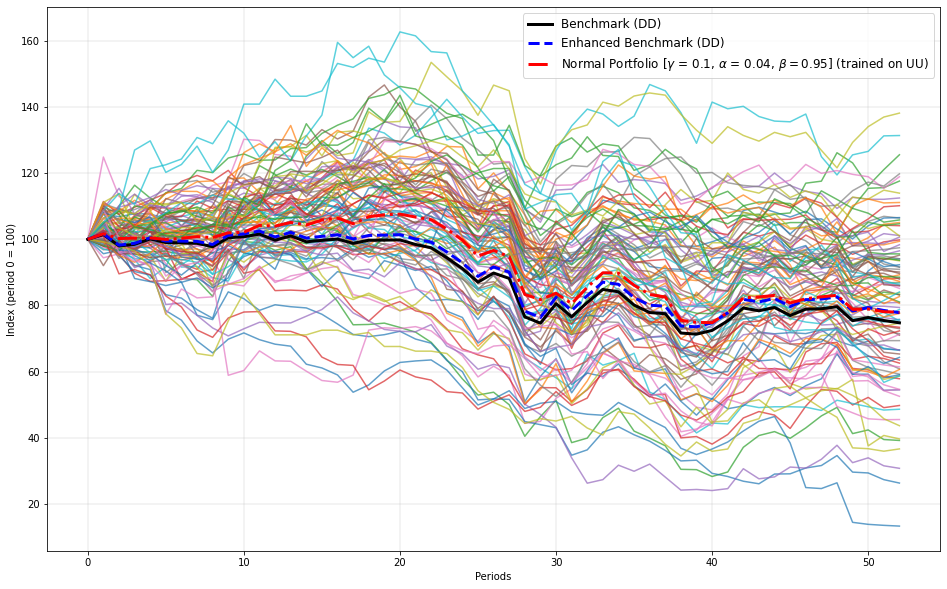

In [396]:
# Portfolio
portfolio = np.matmul(AssetsOoS, optimalAllocation);

# Create figure
fig, ax = plt.subplots(figsize=(16, 10))

# Selected data
selectedData = AssetsOoS;
selectedData = np.cumprod(selectedData + 1,axis=0) * 100;
ax.plot(selectedData[:,selectedData[-1,:] < 160], alpha = 0.7);
    
# Plot index
intermediateIndex = np.transpose(IndexOoS);
intermediateIndex = np.cumprod(intermediateIndex + 1)
index = intermediateIndex * 100;
ax.plot(index, label="Benchmark (DD)", linestyle='-', linewidth=3, color = 'black', alpha=1.0)

# Plot enhanced index
intermediateIndex = np.transpose(IndexOoS);
intermediateIndex = np.cumprod(intermediateIndex + alphaWeekly + 1)
enhancedIndex = intermediateIndex * 100;
ax.plot(enhancedIndex, label="Enhanced Benchmark (DD)", linestyle='--', linewidth=3, color = 'blue', alpha=1.0)

# Plot portfolio
portfolioIndexed = np.cumprod(portfolio + 1) * 100;
ax.plot(portfolioIndexed, label=r'Normal Portfolio [$\gamma$ = {}, $\alpha$ = {}, $\beta = {}$] (trained on {})'.format(round(gamma, 2), round(alpha, 2), round(beta, 2), whichData), linestyle='-.', linewidth=3, color = 'red', alpha=1.0)

# Title and labels
#ax.set_title("Plot of Selected Data in Indtrack1.txt")
ax.set_xlabel("Periods")
ax.set_ylabel("Index (period 0 = 100)")

# Legend
ax.legend(loc="best", fontsize="large")

# Grid lines
ax.grid(True, linestyle='-', linewidth=0.3)

# Color palette
colors = plt.cm.viridis(np.linspace(0, 1, N+1))
#ax.set_prop_cycle('color', colors)

# Show plot
plt.show()

In [340]:
enhancedReturns = np.array([(enhancedIndex[i+1]/enhancedIndex[i] - 1) for i in range(0,len(enhancedIndex)-1)]);
portfolioReturns = np.array([(portfolioIndexed[i+1]/portfolioIndexed[i] - 1) for i in range(0,len(portfolioIndexed)-1)]);
np.corrcoef(enhancedReturns, portfolioReturns)

array([[1.        , 0.94372786],
       [0.94372786, 1.        ]])

## Out-of-Sample Testing (DU)

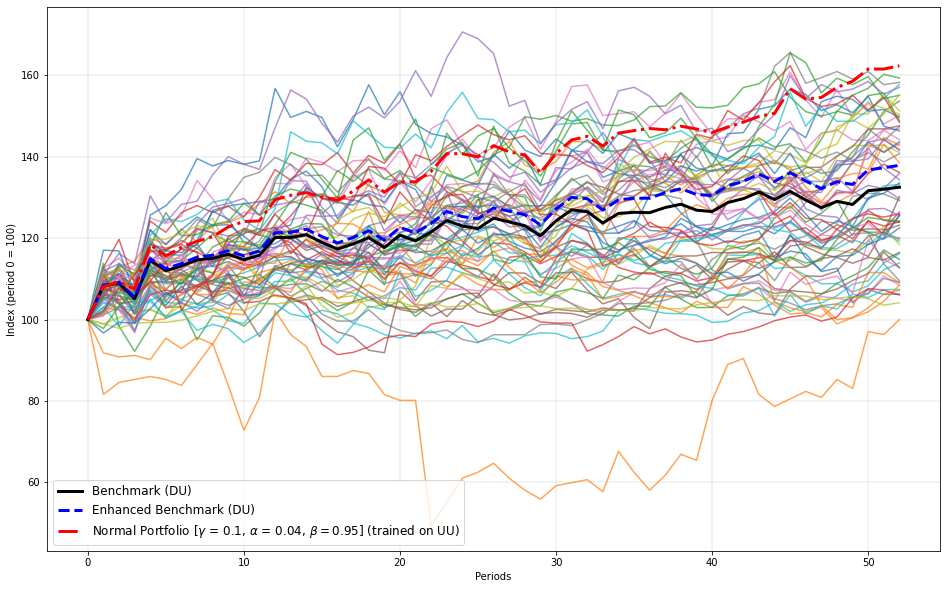

In [395]:
# Portfolio
portfolio = np.matmul(AssetsOoS1, optimalAllocation);

# Create figure
fig, ax = plt.subplots(figsize=(16, 10))

# Selected data
selectedData = AssetsOoS1;
selectedData = np.cumprod(selectedData + 1,axis=0) * 100;
ax.plot(selectedData[:,selectedData[-1,:] < 160], alpha = 0.7);
    
# Plot index
intermediateIndex = np.transpose(IndexOoS1);
intermediateIndex = np.cumprod(intermediateIndex + 1)
index = intermediateIndex * 100;
ax.plot(index, label="Benchmark (DU)", linestyle='-', linewidth=3, color = 'black', alpha=1.0)

# Plot enhanced index
intermediateIndex = np.transpose(IndexOoS1);
intermediateIndex = np.cumprod(intermediateIndex + alphaWeekly + 1)
enhancedIndex = intermediateIndex * 100;
ax.plot(enhancedIndex, label="Enhanced Benchmark (DU)", linestyle='--', linewidth=3, color = 'blue', alpha=1.0)

# Plot portfolio
portfolioIndexed = np.cumprod(portfolio + 1) * 100;
ax.plot(portfolioIndexed, label=r'Normal Portfolio [$\gamma$ = {}, $\alpha$ = {}, $\beta = {}$] (trained on {})'.format(round(gamma, 2), round(alpha, 2), round(beta, 2), whichData), linestyle='-.', linewidth=3, color = 'red', alpha=1.0)

# Title and labels
#ax.set_title("Plot of Selected Data in Indtrack1.txt")
ax.set_xlabel("Periods")
ax.set_ylabel("Index (period 0 = 100)")

# Legend
ax.legend(loc="best", fontsize="large")

# Grid lines
ax.grid(True, linestyle='-', linewidth=0.3)

# Color palette
colors = plt.cm.viridis(np.linspace(0, 1, N+1))
#ax.set_prop_cycle('color', colors)

# Show plot
plt.show()

In [342]:
enhancedReturns = np.array([(enhancedIndex[i+1]/enhancedIndex[i] - 1) for i in range(0,len(enhancedIndex)-1)]);
portfolioReturns = np.array([(portfolioIndexed[i+1]/portfolioIndexed[i] - 1) for i in range(0,len(portfolioIndexed)-1)]);
np.corrcoef(enhancedReturns, portfolioReturns)

array([[1.        , 0.93413944],
       [0.93413944, 1.        ]])

## Out-of-Sample Testing (UD)

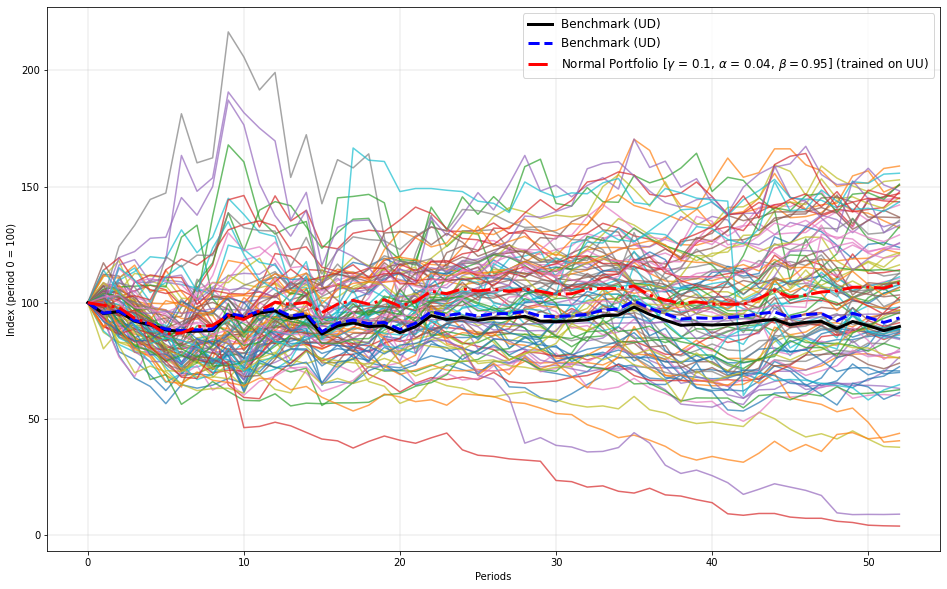

In [394]:
# Portfolio
portfolio = np.matmul(AssetsOoS2, optimalAllocation);

# Create figure
fig, ax = plt.subplots(figsize=(16, 10))

# Selected data
selectedData = AssetsOoS2;
selectedData = np.cumprod(selectedData + 1,axis=0) * 100;
ax.plot(selectedData[:,selectedData[-1,:] < 160], alpha = 0.7);
    
# Plot index
intermediateIndex = np.transpose(IndexOoS2);
intermediateIndex = np.cumprod(intermediateIndex + 1)
index = intermediateIndex * 100;
ax.plot(index, label="Benchmark (UD)", linestyle='-', linewidth=3, color = 'black', alpha=1.0)

# Plot enhanced index
intermediateIndex = np.transpose(IndexOoS2);
intermediateIndex = np.cumprod(intermediateIndex + alphaWeekly + 1)
enhancedIndex = intermediateIndex * 100;
ax.plot(enhancedIndex, label="Benchmark (UD)", linestyle='--', linewidth=3, color = 'blue', alpha=1.0)

# Plot portfolio
portfolioIndexed = np.cumprod(portfolio + 1) * 100;
ax.plot(portfolioIndexed, label=r'Normal Portfolio [$\gamma$ = {}, $\alpha$ = {}, $\beta = {}$] (trained on {})'.format(round(gamma, 2), round(alpha, 2), round(beta, 2), whichData), linestyle='-.', linewidth=3, color = 'red', alpha=1.0)

# Title and labels
#ax.set_title("Plot of Selected Data in Indtrack1.txt")
ax.set_xlabel("Periods")
ax.set_ylabel("Index (period 0 = 100)")

# Legend
ax.legend(loc="best", fontsize="large")

# Grid lines
ax.grid(True, linestyle='-', linewidth=0.3)

# Color palette
colors = plt.cm.viridis(np.linspace(0, 1, N+1))
#ax.set_prop_cycle('color', colors)

# Show plot
plt.show()

In [344]:
enhancedReturns = np.array([(enhancedIndex[i+1]/enhancedIndex[i] - 1) for i in range(0,len(enhancedIndex)-1)]);
portfolioReturns = np.array([(portfolioIndexed[i+1]/portfolioIndexed[i] - 1) for i in range(0,len(portfolioIndexed)-1)]);
np.corrcoef(enhancedReturns, portfolioReturns)

array([[1.        , 0.81066602],
       [0.81066602, 1.        ]])

## Out-of-Sample Testing (UU)

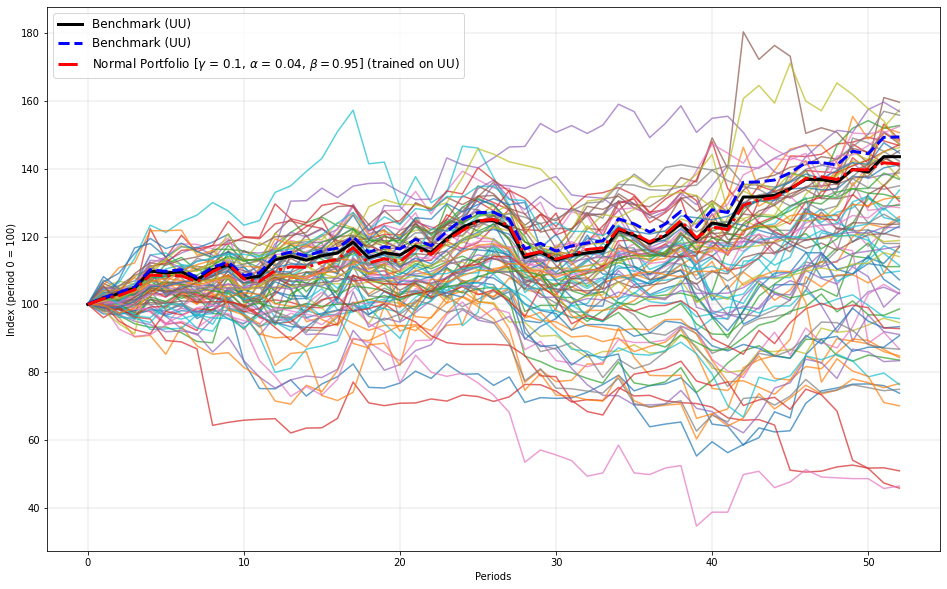

In [393]:
# Portfolio
portfolio = np.matmul(AssetsOoS3, optimalAllocation);

# Create figure
fig, ax = plt.subplots(figsize=(16, 10))

# Selected data
selectedData = AssetsOoS3;
selectedData = np.cumprod(selectedData + 1,axis=0) * 100;
ax.plot(selectedData[:,selectedData[-1,:] < 160], alpha = 0.7);
    
# Plot index
intermediateIndex = np.transpose(IndexOoS3);
intermediateIndex = np.cumprod(intermediateIndex + 1)
index = intermediateIndex * 100;
ax.plot(index, label="Benchmark (UU)", linestyle='-', linewidth=3, color = 'black', alpha=1.0)

# Plot enhanced index
intermediateIndex = np.transpose(IndexOoS3);
intermediateIndexAlpha = np.cumprod(intermediateIndex + alphaWeekly + 1)
enhancedIndex = intermediateIndexAlpha * 100;
ax.plot(enhancedIndex, label="Benchmark (UU)", linestyle='--', linewidth=3, color = 'blue', alpha=1.0)

# Plot portfolio
portfolioIndexed = np.cumprod(portfolio + 1) * 100;
ax.plot(portfolioIndexed, label=r'Normal Portfolio [$\gamma$ = {}, $\alpha$ = {}, $\beta = {}$] (trained on {})'.format(round(gamma, 2), round(alpha, 2), round(beta, 2), whichData), linestyle='-.', linewidth=3, color = 'red', alpha=1.0)

# Title and labels
#ax.set_title("Plot of Selected Data in Indtrack1.txt")
ax.set_xlabel("Periods")
ax.set_ylabel("Index (period 0 = 100)")

# Legend
ax.legend(loc="best", fontsize="large")

# Grid lines
ax.grid(True, linestyle='-', linewidth=0.3)

# Color palette
colors = plt.cm.viridis(np.linspace(0, 1, N+1))
#ax.set_prop_cycle('color', colors)

# Show plot
plt.show()

In [346]:
enhancedReturns = np.array([(enhancedIndex[i+1]/enhancedIndex[i] - 1) for i in range(0,len(enhancedIndex)-1)]);
portfolioReturns = np.array([(portfolioIndexed[i+1]/portfolioIndexed[i] - 1) for i in range(0,len(portfolioIndexed)-1)]);
np.corrcoef(enhancedReturns, portfolioReturns)

array([[1.        , 0.96891436],
       [0.96891436, 1.        ]])

## Testing Affine Functions for Corollary 5.1 (DRO)

In [363]:
def first(x):
    return np.maximum(x, -x);

In [389]:
def second(x, tau):
    return np.maximum(-x - tau, 0);

In [467]:
x = np.linspace(-5,5,1000);
tau = np.linspace(0,2,1);

In [468]:
tau

array([0.])

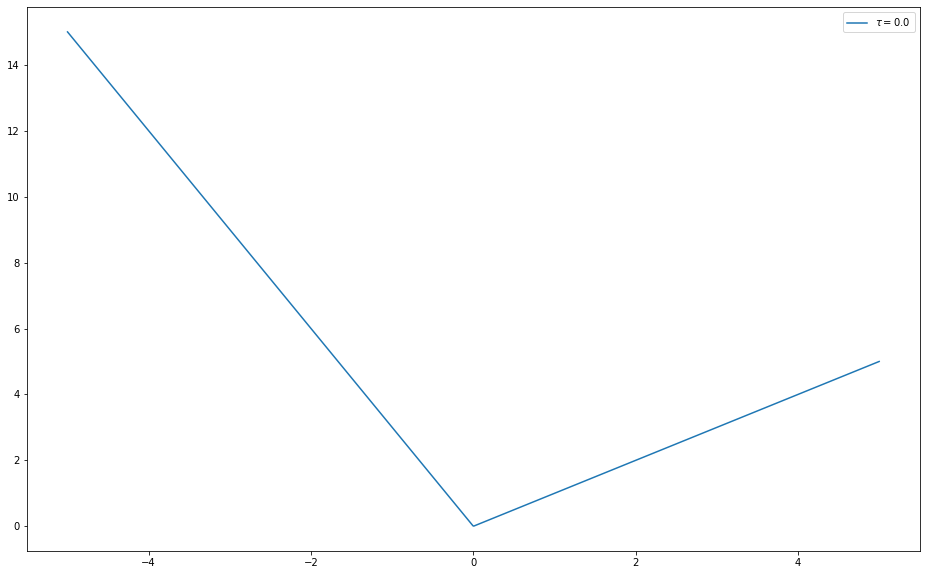

In [469]:
beta = 0.95;
gamma = 0.1;

plt.figure(figsize=(16,10));
for idx, t in enumerate(tau):
    plt.plot(x, first(x) + (gamma/(1-beta))*second(x, tau[idx]) + t*gamma, label=r"$\tau={}$".format(tau[idx]));
plt.legend();
plt.show();

Then we test is with the parameterized affine functions.

In [464]:
beta = 0.95;
gamma = 0.1;

def affine1(x, tau):
    ak = (1 - gamma/(1 - beta));
    bk = (gamma*tau*(1 - 1/(1-beta)));
    return(ak*x + bk);

def affine2(x, tau):
    ak = -(1 + gamma/(1 - beta));
    bk = (gamma*tau*(1 - 1/(1-beta)));
    return(ak*x + bk);

def affine3(x, tau):
    ak = 1;
    bk = gamma*tau;
    return(ak*x + bk);

def affine4(x, tau):
    ak = -1;
    bk = gamma*tau;
    return(ak*x + bk);


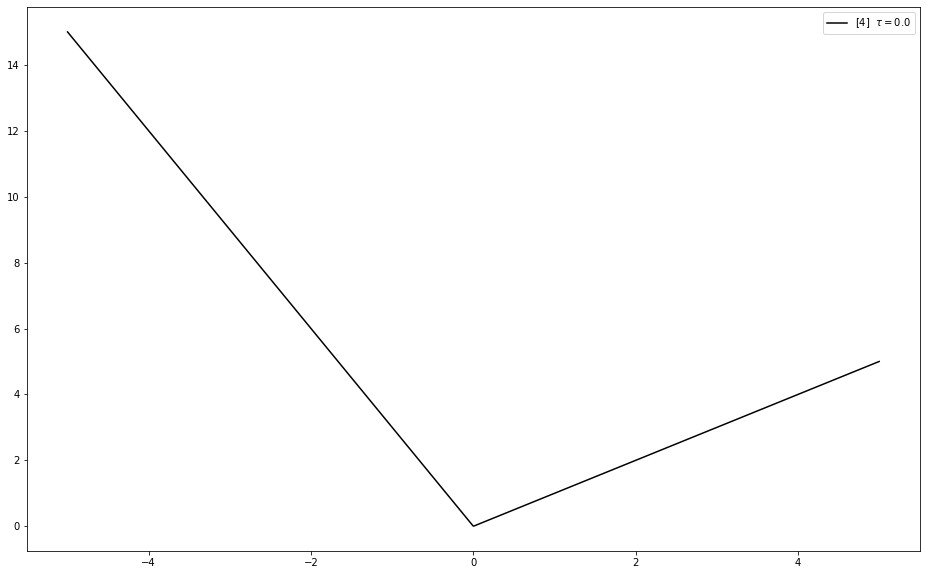

In [466]:
x = np.linspace(-5,5,1000);
tau = np.linspace(0,2,1);

plt.figure(figsize=(16,10));
for idx, t in enumerate(tau):
    #plt.plot(x, affine1(x, tau[idx]), label=r"$[1] \ \ \tau={}$".format(tau[idx]));
    #plt.plot(x, affine2(x, tau[idx]), label=r"$[2] \ \ \tau={}$".format(tau[idx]));
    #plt.plot(x, affine3(x, tau[idx]), label=r"$[3] \ \ \tau={}$".format(tau[idx]));
    #plt.plot(x, affine4(x, tau[idx]), label=r"$[4] \ \ \tau={}$".format(tau[idx]));
    plt.plot(x, np.maximum(np.maximum(affine1(x, tau[idx]), affine2(x, tau[idx])), np.maximum(affine3(x, tau[idx]), affine4(x, tau[idx]))), label=r"$[4] \ \ \tau={}$".format(tau[idx]), color="black");
plt.legend();
plt.show();

In [429]:
test1 = affine1(x, tau[0]);
test2 = affine2(x, tau[0]);
test3 = affine3(x, tau[0]);
test4 = affine4(x, tau[0]);

array([ 7.64000000e+01,  7.62698699e+01,  7.61397397e+01,  7.60096096e+01,
        7.58794795e+01,  7.57493493e+01,  7.56192192e+01,  7.54890891e+01,
        7.53589590e+01,  7.52288288e+01,  7.50986987e+01,  7.49685686e+01,
        7.48384384e+01,  7.47083083e+01,  7.45781782e+01,  7.44480480e+01,
        7.43179179e+01,  7.41877878e+01,  7.40576577e+01,  7.39275275e+01,
        7.37973974e+01,  7.36672673e+01,  7.35371371e+01,  7.34070070e+01,
        7.32768769e+01,  7.31467467e+01,  7.30166166e+01,  7.28864865e+01,
        7.27563564e+01,  7.26262262e+01,  7.24960961e+01,  7.23659660e+01,
        7.22358358e+01,  7.21057057e+01,  7.19755756e+01,  7.18454454e+01,
        7.17153153e+01,  7.15851852e+01,  7.14550551e+01,  7.13249249e+01,
        7.11947948e+01,  7.10646647e+01,  7.09345345e+01,  7.08044044e+01,
        7.06742743e+01,  7.05441441e+01,  7.04140140e+01,  7.02838839e+01,
        7.01537538e+01,  7.00236236e+01,  6.98934935e+01,  6.97633634e+01,
        6.96332332e+01,  